# Supplementary figure 1

In [1]:
import numpy as np
import pandas as pd

from scipy.fftpack import dct, idct
from sklearn.decomposition import PCA

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from music21 import converter
matplotlib.style.use('styles.mplstyle')

import sys
import os
import glob
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours

In [2]:
def load_contours(fn, num_samples=100):
    df = pd.read_csv(fn)
    contours = df[[str(i) for i in range(num_samples)]].values
    return contours, df

contours, df = load_contours('../data/phrase-contours/boehme-phrase-contours.csv')

In [3]:
def alpha(k, N):
    if k == 0:
        return 1 / np.sqrt(N)
    else:
        return np.sqrt(2/N)
    
def cosine(n, k, N):
    return alpha(k, N) * np.cos(np.pi * (2*n + 1) * k / (2*N))

def dct_matrix(N):
    """Discrete Cosine Transform NxN matrix where every column is a
    discrete cosine function. Columns are normalized, so the output
    is an orthogonal matrix."""
    ns = np.arange(N)
    return np.array([cosine(ns, k, N) for k in ns]).T

### Average contours

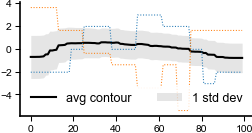

In [4]:
def show_avg_contour(contours, f=1, num_examples=2, color='k'):
    xs = np.arange(contours.shape[1])
    contours = contours - contours.mean(axis=1)[:, np.newaxis]
    mean = contours.mean(axis=0)
    std = f/2 * contours.std(axis=0)
    plt.plot(xs, mean, color, lw=1, label=f'avg contour')
    plt.fill_between(xs, mean-std, mean+std, alpha=.1, 
                     color=color, label=f'1 std dev', lw=0)    
    plt.plot(xs, contours[:num_examples, :].T, ':', lw=.5) 
#     plt.plot(0, 0, 'k:', lw=.5, label='example')
    plt.legend(ncol=2)
    
plt.figure(figsize=(2, 1))
show_avg_contour(contours)

### PCA

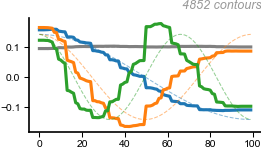

In [5]:
def show_pca(contours, n_components=4):
    pca = PCA(n_components=4)
    pca.fit(contours)
    N = contours.shape[1]
    xs = np.arange(0, N)
    show_num_contours(contours.shape[0], plt.gca())
    for k in range(n_components):
        comp = pca.components_[k]
        v = cosine(xs, k, N)
        
        if np.linalg.norm(-1*comp - v) < np.linalg.norm(comp - v):
            comp = -1 * comp
    
        color = '0.5' if k == 0 else f'C{k-1}'
        plt.plot(xs, comp, label=f'$C_{k}$', c=color)
        plt.plot(xs, v, c=color, ls='--', alpha=.5, lw=.5)

plt.figure(figsize=(2, 1))
show_pca(contours, n_components=4)

### Reconstruction error

In [6]:
def dct_mse(contours, dim):
    N = contours.shape[1]
    coeff = dct(contours, norm='ortho')
    coeff[:, dim+1:] = 0
    reconstruction = idct(coeff, norm='ortho', n=N)
    return np.mean((contours - reconstruction) ** 2)

def dct_mses(contours, dims):
    return np.array([dct_mse(contours, d) for d in dims])

In [7]:
def pca_mse(contours, pca, dim):
    coeff = pca.transform(contours)
    coeff[:, dim+1:] = 0
    reconstruction = pca.inverse_transform(coeff)
    return np.mean((contours - reconstruction) ** 2)

def pca_mses(contours, pca, dims):
    return np.array([pca_mse(contours, pca, d) for d in dims])

# pca_loss(X_de, pca_de, 5)

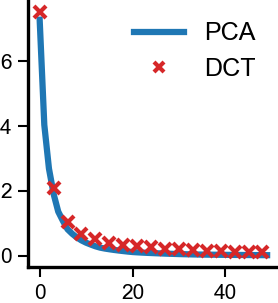

In [8]:
def show_reconstruction_error(contours, skip=3, ds=np.arange(50), **kwargs):
    pca = PCA(n_components=contours.shape[1], svd_solver='full')
    pca.fit(contours)
    l, = plt.plot(ds, pca_mses(contours, pca, ds), **kwargs, label='PCA')
    plt.plot(ds[::skip], dct_mses(contours, ds)[ds][::skip], 'x', c='C3', label='DCT')
    plt.legend()
        
plt.figure(figsize=cm2inch(8.2/3, 3))
show_reconstruction_error(contours)

### Combined figure

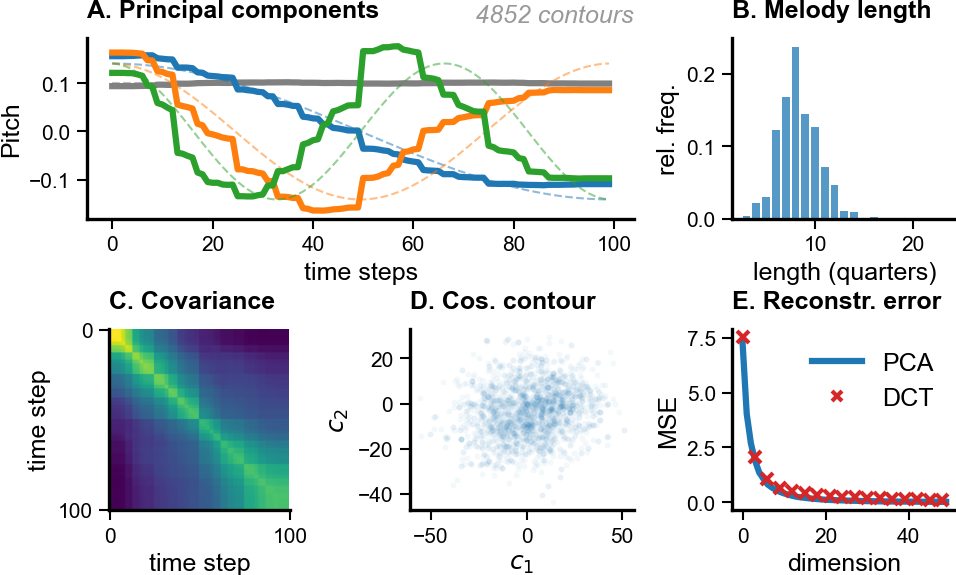

In [9]:
def plot_dataset(contours, durations):
    gs = gridspec.GridSpec(2, 3)

    ax = fig.add_subplot(gs[0, 0:2])
    show_pca(contours)
    title('A. Principal components')
    plt.ylabel('Pitch')
    plt.xlabel('time steps')

    fig.add_subplot(gs[0,2])
    sns.histplot(durations, stat='probability', discrete=True, lw=0, shrink=.8,)
    plt.ylabel('rel. freq.')
    plt.xlabel('length (quarters)')
    title('B. Melody length')

    fig.add_subplot(gs[1, 0])
    plt.imshow(np.cov(contours.T))
    title('C. Covariance')
    plt.xlabel('time step')
    plt.ylabel('time step')
    plt.xticks([0, 100])
    plt.yticks([0, 100])

    fig.add_subplot(gs[1, 1])
    x, y = dct(contours, norm='ortho')[:, 1:3].T
    plt.scatter(x[:2000], y[:2000], s=2, alpha=.05, linewidths=0)
    title('D. Cos. contour')
    plt.xlabel('$c_1$')
    plt.ylabel('$c_2$')

    fig.add_subplot(gs[1, 2])
    show_reconstruction_error(contours)
    title('E. Reconstr. error')
    plt.xlabel('dimension')
    plt.ylabel('MSE')
    plt.tight_layout(pad=0.2)

contours, df = load_contours('../data/phrase-contours/boehme-phrase-contours.csv')    
fig = plt.figure(figsize=cm2inch(8.2, 5))
plot_dataset(contours, df['phrase_length'])

In [10]:
def toeplitz_difference(S):
    diffs = np.zeros(S.shape)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            k = j - i
            avg = np.mean(np.diag(S, k))
            diffs[i, j] = S[i, j] - avg
    return diffs

In [13]:
S = np.cov(contours.T)

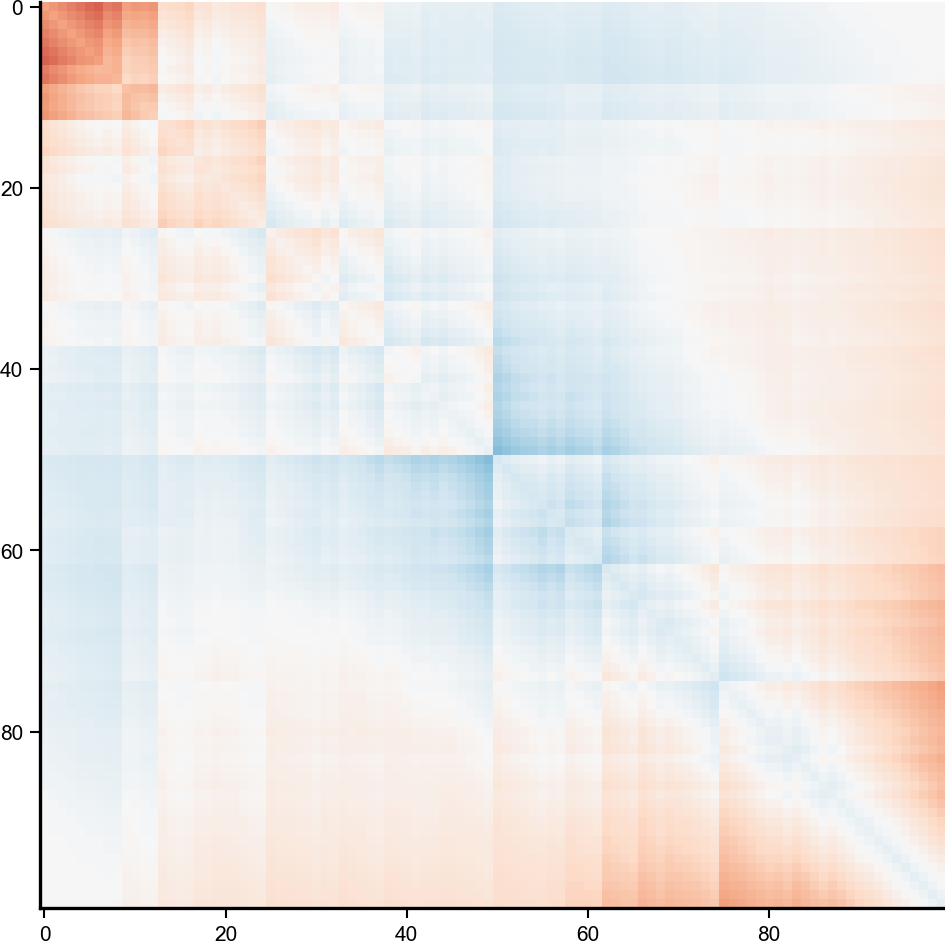

In [18]:
plt.imshow(toeplitz_difference(S), 
           cmap='RdBu_r', vmin=-10, vmax=10)

## Plot all datasets

In [42]:
def generate_figure(path, duration_field, prefix='fig-'):
    fn = os.path.basename(os.path.splitext(path)[0])
    contours, df = load_contours(path)
    plot_dataset(contours, df[duration_field])
    plt.savefig(f'../figures/suppl-S2/{prefix}{fn}.pdf')
    plt.close()

# fig = plt.figure(figsize=cm2inch(8.2, 5))    
# generate_figure('../data/phrase-contours/boehme-phrase-contours.csv', 
#                 'phrase_length', prefix='phrase-')

In [43]:
# Phrase contours
for path in glob.glob('../data/phrase-contours/*.csv'):
    fig = plt.figure(figsize=cm2inch(8.2, 5))
    generate_figure(path, 'phrase_length', prefix='phrase-')

In [44]:
# Motif contours
for path in glob.glob('../data/motif-contours/*.csv'):
    fig = plt.figure(figsize=cm2inch(8.2, 5))
    generate_figure(path, 'duration', prefix='motif-')

In [45]:
for path in glob.glob('../data/song-contours/*.csv'):
    fig = plt.figure(figsize=cm2inch(8.2, 5))
    try:
        generate_figure(path, 'duration', prefix='song-')
        plt.close()
    except:
        print('Skip', path)

Skip ../data/song-contours/densmore-pueblo.csv
Skip ../data/song-contours/densmore-maidu.csv
Skip ../data/song-contours/densmore-choctaw.csv
Skip ../data/song-contours/densmore-ojibway.csv
Skip ../data/song-contours/densmore-pawnee.csv
